# POSTTEST 6

## Link dataset : https://docs.google.com/spreadsheets/d/15HDXsDWn4AMPe-dO-yJ8ENIOOThimtkw5LW7DfhCd4c/edit#gid=877757415

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout
from colorama import Fore, Back, Style

### Reading dataset

In [2]:
df = pd.read_csv('autos.csv',encoding="utf-8")

### Preprocessing dataset

In [3]:
# 1. DateTime Conversion --> Drop 'dateCrawled' and 'lastSeen'
df.drop(['lastSeen', 'dateCrawled'], axis=1, inplace=True)
df['dateCreated'] = pd.to_datetime(df['dateCreated'])

# 2. Drop the 'nrOfPictures', 'seller', 'offerType' columns
df.drop('nrOfPictures', axis=1, inplace=True)
df.drop('seller', axis=1, inplace=True)
df.drop('offerType', axis=1, inplace=True)

# 3. Define a range for the 'yearOfRegistration'
df = df[df['yearOfRegistration'].between(1980, 2023)]

# 4. German to English, as best as I can
df['gearbox'] = df['gearbox'].apply(lambda g: 'Manual' if g == 'manuell' else 'Automatic')
df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda g: 'Yes' if g == 'ja' else 'No' if g =='nein' else 'NaN')
df.loc[df['fuelType'] == 'benzin', 'fuelType'] = 'Petrol'
df.loc[df['fuelType'] == 'andere', 'fuelType'] = 'Other'

# drop null values
df.dropna(inplace=True)

# Drop cars with unacceptable prices
df = df[df['price'].between(200, 20_000)]

# Drop cars with extreme powerPS
df = df[(df['powerPS'] > 0) & (df['powerPS'] <= 1000)]

# Add the 'age' column
current_year = 2023
df['age'] = current_year - df['yearOfRegistration']

# Drop unnecessary columns and rows
df.drop(['postalCode', 'dateCreated', 'name', 'monthOfRegistration', 'yearOfRegistration'], axis=1, inplace=True)
df = df[df['fuelType'] != 'Other']
df = df[df['notRepairedDamage'] != 'NaN']

# Categorical to Numerical
categorical_features = ['vehicleType', 'fuelType', 'brand', 'model', 'abtest', 'notRepairedDamage', 'gearbox']
le = LabelEncoder()

for categorical_feature in categorical_features:
    df[categorical_feature] = le.fit_transform(df[categorical_feature])

### MEnentukan fitur dan target sebelum modeling

In [4]:
features = df.drop(['price'], axis=1)
target = df['price']

scaler = StandardScaler()
numerical_features = ['kilometer', 'powerPS', 'age']
features[numerical_features] = scaler.fit_transform(features[numerical_features])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=666, train_size=0.85)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=666, train_size=0.8235)

### Mempersiapkan model training

In [6]:
epoch = 50
batch_size = 512
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_model.h5', monitor='val_mean_absolute_error', mode='min', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

### Membuat layer model

In [7]:
model = Sequential()

model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', name='Dense_1'))
model.add(Dropout(0.2, name='Dropout_1'))

model.add(Dense(64, 'relu', name='Dense_2'))
model.add(Dropout(0.2, name='Dropout_2'))

model.add(Dense(128, 'relu', name='Dense_3'))
model.add(Dropout(0.2, name='Dropout_3'))

model.add(Dense(64, 'relu', name='Dense_4'))
model.add(Dropout(0.2, name='Dropout_4'))

model.add(Dense(32, 'relu', name='Dense_5'))

model.add(Dense(1, 'linear', name='Predictor'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])

### Training model

In [8]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epoch,
                    callbacks=[mc, lr_schedule, es])

Epoch 1/50
317/318 [============================>.] - ETA: 0s - loss: 34948884.0000 - mean_absolute_error: 4329.6172
Epoch 1: val_mean_absolute_error improved from inf to 4027.11060, saving model to .\best_model.h5
318/318 [==============================] - 8s 16ms/step - loss: 34932076.0000 - mean_absolute_error: 4328.6436 - val_loss: 33835780.0000 - val_mean_absolute_error: 4027.1106 - lr: 0.0010
Epoch 2/50
  5/318 [..............................] - ETA: 4s - loss: 31233414.0000 - mean_absolute_error: 4161.8428

D:\SEMESTER 5\Praktikum KB\POSTTEST1\venv_C2-21\ihsan_135\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/318 [============================>.] - ETA: 0s - loss: 30040694.0000 - mean_absolute_error: 4077.6206
Epoch 2: val_mean_absolute_error did not improve from 4027.11060
318/318 [==============================] - 4s 13ms/step - loss: 30051602.0000 - mean_absolute_error: 4077.6616 - val_loss: 34144576.0000 - val_mean_absolute_error: 4039.3801 - lr: 9.0484e-04
Epoch 3/50
315/318 [============================>.] - ETA: 0s - loss: 29799278.0000 - mean_absolute_error: 4062.9377
Epoch 3: val_mean_absolute_error did not improve from 4027.11060
318/318 [==============================] - 4s 13ms/step - loss: 29787214.0000 - mean_absolute_error: 4062.4265 - val_loss: 34680848.0000 - val_mean_absolute_error: 4062.1562 - lr: 8.1873e-04
Epoch 4/50
316/318 [============================>.] - ETA: 0s - loss: 29591154.0000 - mean_absolute_error: 4052.7991
Epoch 4: val_mean_absolute_error did not improve from 4027.11060
318/318 [==============================] - 4s 13ms/step - loss: 29598140.0000 - mea

### Menampilkan hasil training

In [12]:
from tensorflow.keras.models import load_model

dnn_model = load_model('./best_model.h5')
dnn_eval = model.evaluate(X_test, y_test)
dnn_preds = model.predict(X_test)

print(f"{Fore.BLUE}DNN - Test set\n\nMSE: {Fore.RED}{dnn_eval[0]}\n{Fore.BLUE}MAE: {Fore.RED}{dnn_eval[1]:.2f}")
print(f"{Fore.BLUE}R2-Score: {Fore.RED}{r2_score(y_test, dnn_preds):.3f}")

1089/1089 [==============================] - 3s 2ms/step
DNN - Test set

MSE: 29085252.0
MAE: 3746.93
R2-Score: -0.310


### Menampilkan grafiknya

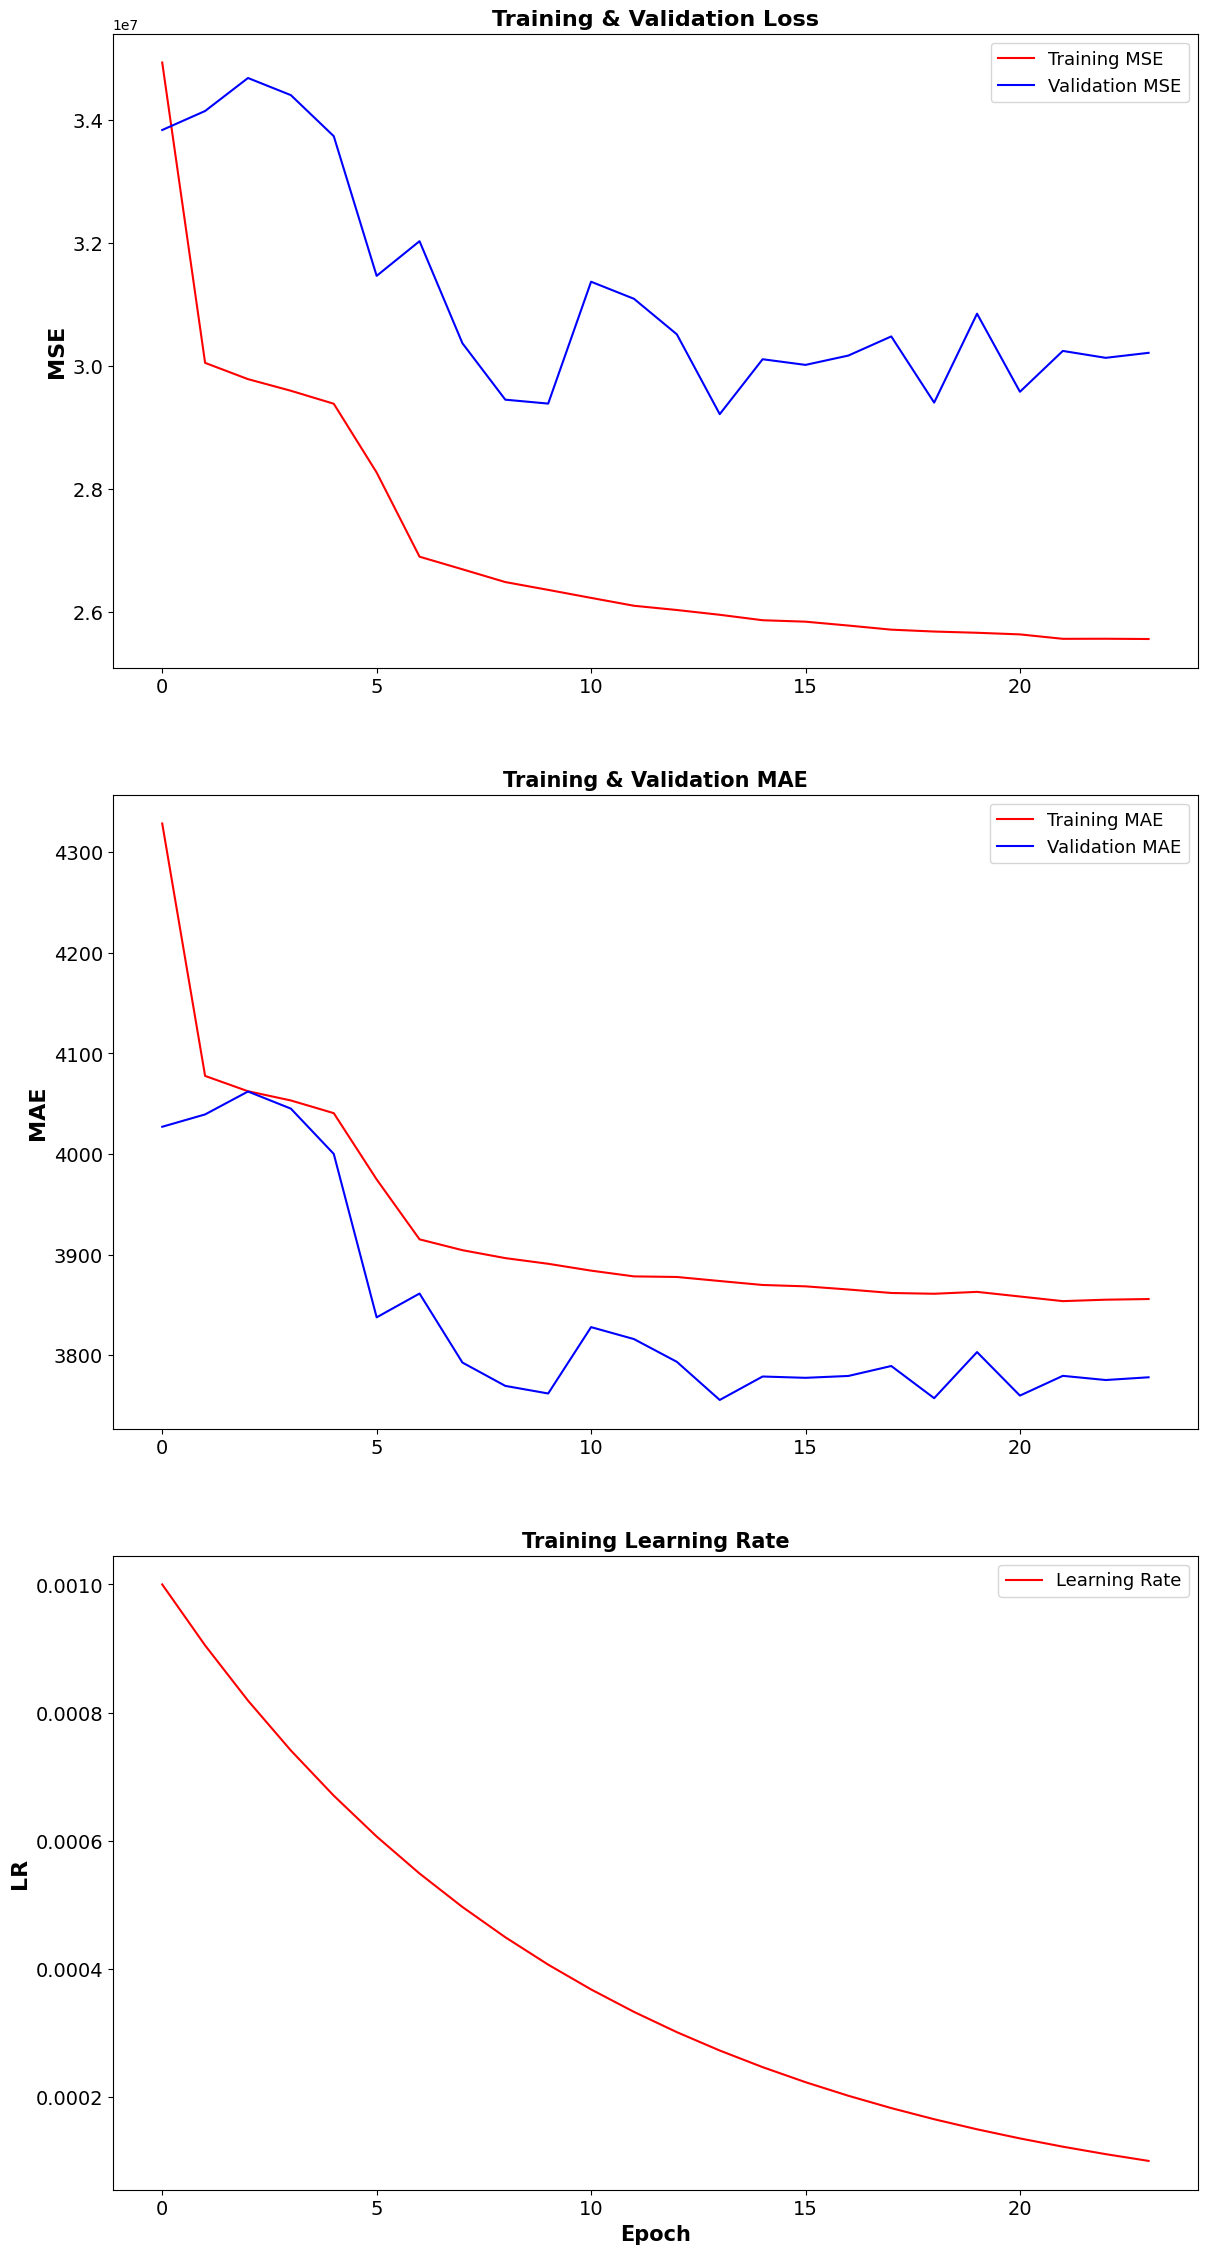

In [10]:
lr = history.history['lr']
loss = history.history['loss']
val_loss = history.history['val_loss']
t_mae = history.history['mean_absolute_error']
v_mae = history.history['val_mean_absolute_error']

plt.figure(figsize=(14, 28))

# MSE
plt.subplot(3, 1, 1)
plt.plot(loss, label='Training MSE', color='r')
plt.plot(val_loss, label='Validation MSE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('MSE', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=16, weight='bold')

# MAE
plt.subplot(3, 1, 2)
plt.plot(t_mae, label='Training MAE', color='r')
plt.plot(v_mae, label='Validation MAE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.ylabel('MAE', fontsize=16, weight='bold')
plt.title('Training & Validation MAE', fontsize=15, weight='bold')

# Learning Rate
plt.subplot(3, 1, 3)
plt.plot(lr, label='Learning Rate', color='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('LR', fontsize=16, weight='bold')
plt.title('Training Learning Rate', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()